# Image classification using colorization as a pretext task

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
from skimage import color

We start by defining some constants and setting the device that we will be using.

In [2]:
batch_size = 512
learning_rate = 1e-3
use_gpu = True
num_workers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Data preparation

We load the CIFAR10 dataset, transforming the images into tensors.

In [3]:
transform_img_train = transforms.Compose([
    transforms.ToTensor(),
])

# Use the same transform for the test dataset
transform_img_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10('./data/CIFAR10', train=True, transform=transform_img_train, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10('./data/CIFAR10', train=False, transform=transform_img_test, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170498071/170498071 [00:05<00:00, 29089501.47it/s]


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


Then, we split the dataset randomply into three partitions: train, test and validation.

In [4]:
indices = list(range(len(test_dataset)))
np.random.shuffle(indices)

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(test_dataset, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

## Model definition

We define the models that we will be using. First, the `ColorNet` model, from the colorization class, from which we will need to extract the encoder to use in the `RecolorizeAndClassify` model for classification.
For that, we load the state of the previously trained model and pass it to the classification network.

In [5]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # out: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # out: 64 x 8 x 8
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.conv_stack = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # out: 64 x 8 x 8
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # out: 32 x 16 x 16
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),  # out: 2 x 32 x 32
        )

    def forward(self, input):
        x = self.encoder(input)
        x = self.conv_stack(x)
        x = self.decoder(x)

        return x


class RecolorizeAndClassify(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(RecolorizeAndClassify, self).__init__()
        self.encoder = encoder
        self.conv1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(0.5)
        self.relu3 = nn.ReLU()
        self.classifier = nn.Linear(128 * 4 * 4, num_classes)

    def forward(self, input):
        gray_input = torch.mean(input, dim=1, keepdim=True)
        x = self.encoder(gray_input)
        x = self.conv1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.dropout2(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

cnet = ColorNet()

state_dict = torch.load('/models/colorization_weighted_log.pth')
cnet.load_state_dict(state_dict['model'])
cnet.to(device)

combined_model = RecolorizeAndClassify(cnet.encoder, num_classes=10).to(device)
print(combined_model)

RecolorizeAndClassify(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
  )
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu1): ReLU()
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (

## Training the model

To start training the model, we define our loss function and optimizer as well as the training loop

In [6]:
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer =  torch.optim.Adam(combined_model.parameters(), lr=learning_rate)

In [7]:

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [8]:
num_epochs = 25
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, combined_model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, combined_model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': combined_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': combined_model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")


Start training...

Epoch 1


100%|██████████| 97/97 [00:12<00:00,  7.80it/s]


Train loss: 1.487 	 Train acc: 0.456


100%|██████████| 16/16 [00:01<00:00, 11.53it/s]


Val loss: 1.297 	 Val acc: 0.545

Epoch 2


100%|██████████| 97/97 [00:07<00:00, 13.47it/s]


Train loss: 1.136 	 Train acc: 0.595


100%|██████████| 16/16 [00:01<00:00, 13.50it/s]


Val loss: 1.100 	 Val acc: 0.609

Epoch 3


100%|██████████| 97/97 [00:06<00:00, 14.23it/s]


Train loss: 0.999 	 Train acc: 0.644


100%|██████████| 16/16 [00:01<00:00, 14.30it/s]


Val loss: 1.014 	 Val acc: 0.641

Epoch 4


100%|██████████| 97/97 [00:06<00:00, 14.52it/s]


Train loss: 0.913 	 Train acc: 0.677


100%|██████████| 16/16 [00:01<00:00, 14.14it/s]


Val loss: 1.018 	 Val acc: 0.642

Epoch 5


100%|██████████| 97/97 [00:06<00:00, 14.98it/s]


Train loss: 0.833 	 Train acc: 0.705


100%|██████████| 16/16 [00:01<00:00, 13.63it/s]


Val loss: 0.931 	 Val acc: 0.675

Epoch 6


100%|██████████| 97/97 [00:07<00:00, 13.44it/s]


Train loss: 0.774 	 Train acc: 0.727


100%|██████████| 16/16 [00:01<00:00, 14.24it/s]


Val loss: 1.016 	 Val acc: 0.654

Epoch 7


100%|██████████| 97/97 [00:06<00:00, 14.46it/s]


Train loss: 0.716 	 Train acc: 0.746


100%|██████████| 16/16 [00:01<00:00, 13.92it/s]


Val loss: 0.966 	 Val acc: 0.676

Epoch 8


100%|██████████| 97/97 [00:06<00:00, 14.69it/s]


Train loss: 0.674 	 Train acc: 0.762


100%|██████████| 16/16 [00:01<00:00, 14.12it/s]


Val loss: 0.952 	 Val acc: 0.677

Epoch 9


100%|██████████| 97/97 [00:06<00:00, 14.68it/s]


Train loss: 0.627 	 Train acc: 0.777


100%|██████████| 16/16 [00:01<00:00, 14.13it/s]


Val loss: 0.872 	 Val acc: 0.706

Epoch 10


100%|██████████| 97/97 [00:07<00:00, 13.30it/s]


Train loss: 0.583 	 Train acc: 0.794


100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


Val loss: 0.979 	 Val acc: 0.681

Epoch 11


100%|██████████| 97/97 [00:06<00:00, 14.67it/s]


Train loss: 0.547 	 Train acc: 0.805


100%|██████████| 16/16 [00:01<00:00, 14.18it/s]


Val loss: 0.883 	 Val acc: 0.707

Epoch 12


100%|██████████| 97/97 [00:06<00:00, 14.64it/s]


Train loss: 0.512 	 Train acc: 0.818


100%|██████████| 16/16 [00:01<00:00, 12.59it/s]


Val loss: 1.224 	 Val acc: 0.647

Epoch 13


100%|██████████| 97/97 [00:06<00:00, 14.59it/s]


Train loss: 0.485 	 Train acc: 0.827


100%|██████████| 16/16 [00:01<00:00, 14.25it/s]


Val loss: 0.998 	 Val acc: 0.680

Epoch 14


100%|██████████| 97/97 [00:07<00:00, 13.31it/s]


Train loss: 0.466 	 Train acc: 0.835


100%|██████████| 16/16 [00:01<00:00, 14.17it/s]


Val loss: 1.005 	 Val acc: 0.688

Epoch 15


100%|██████████| 97/97 [00:06<00:00, 14.89it/s]


Train loss: 0.420 	 Train acc: 0.851


100%|██████████| 16/16 [00:01<00:00, 13.06it/s]


Val loss: 0.936 	 Val acc: 0.710

Epoch 16


100%|██████████| 97/97 [00:06<00:00, 15.20it/s]


Train loss: 0.406 	 Train acc: 0.854


100%|██████████| 16/16 [00:01<00:00, 13.81it/s]


Val loss: 1.052 	 Val acc: 0.686

Epoch 17


100%|██████████| 97/97 [00:06<00:00, 14.60it/s]


Train loss: 0.382 	 Train acc: 0.864


100%|██████████| 16/16 [00:01<00:00, 14.48it/s]


Val loss: 1.017 	 Val acc: 0.696

Epoch 18


100%|██████████| 97/97 [00:07<00:00, 13.44it/s]


Train loss: 0.358 	 Train acc: 0.871


100%|██████████| 16/16 [00:01<00:00, 14.50it/s]


Val loss: 0.992 	 Val acc: 0.708

Epoch 19


100%|██████████| 97/97 [00:06<00:00, 14.78it/s]


Train loss: 0.338 	 Train acc: 0.878


100%|██████████| 16/16 [00:01<00:00, 14.26it/s]


Val loss: 1.037 	 Val acc: 0.710

Epoch 20


100%|██████████| 97/97 [00:06<00:00, 15.09it/s]


Train loss: 0.321 	 Train acc: 0.886


100%|██████████| 16/16 [00:01<00:00, 14.27it/s]


Val loss: 0.985 	 Val acc: 0.719

Epoch 21


100%|██████████| 97/97 [00:06<00:00, 14.74it/s]


Train loss: 0.307 	 Train acc: 0.892


100%|██████████| 16/16 [00:01<00:00, 14.37it/s]


Val loss: 1.255 	 Val acc: 0.679

Epoch 22


100%|██████████| 97/97 [00:06<00:00, 14.27it/s]


Train loss: 0.299 	 Train acc: 0.894


100%|██████████| 16/16 [00:01<00:00, 11.06it/s]


Val loss: 1.284 	 Val acc: 0.678

Epoch 23


100%|██████████| 97/97 [00:06<00:00, 14.75it/s]


Train loss: 0.279 	 Train acc: 0.901


100%|██████████| 16/16 [00:01<00:00, 14.14it/s]


Val loss: 1.179 	 Val acc: 0.699

Epoch 24


100%|██████████| 97/97 [00:06<00:00, 14.29it/s]


Train loss: 0.266 	 Train acc: 0.905


100%|██████████| 16/16 [00:01<00:00, 14.23it/s]


Val loss: 1.186 	 Val acc: 0.699

Epoch 25


100%|██████████| 97/97 [00:06<00:00, 14.76it/s]


Train loss: 0.259 	 Train acc: 0.908


100%|██████████| 16/16 [00:01<00:00, 14.18it/s]

Val loss: 1.196 	 Val acc: 0.703
Finished


## Evaluation

To evaluate the model we plot the cross entropy loss and classification accuracy over epochs.

In [13]:
def plot_training_history(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

We see that the model is overfitting after about 10 epochs.

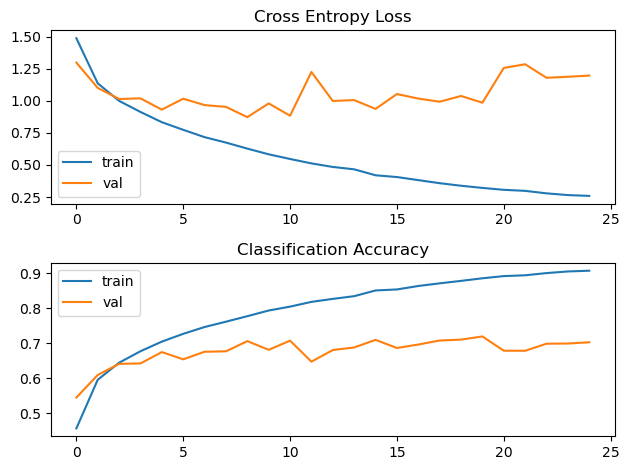

In [14]:
plot_training_history(train_history, val_history)

Finally, we can see the prediction results.

In [15]:
def show_errors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
        if ind >= num_examples:
            break
        X, y = X.to(device), y.to(device)    
        pred = model(X)
        probs = F.softmax(pred, dim=1)
        final_pred = torch.argmax(probs, dim=1)

        plt.subplot(10, 10, ind + 1)
        plt.axis("off")
        plt.text(0, -1, str(y[0].item()), fontsize=14, color='green')  # correct
        plt.text(8, -1, str(final_pred[0].item()), fontsize=14, color='red')  # predicted

        image = np.transpose(X[0].cpu().numpy(), (1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions

        if image.shape[-1] == 1:  # If the image is grayscale, convert to RGB
            image = np.squeeze(image)
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)

    plt.show()


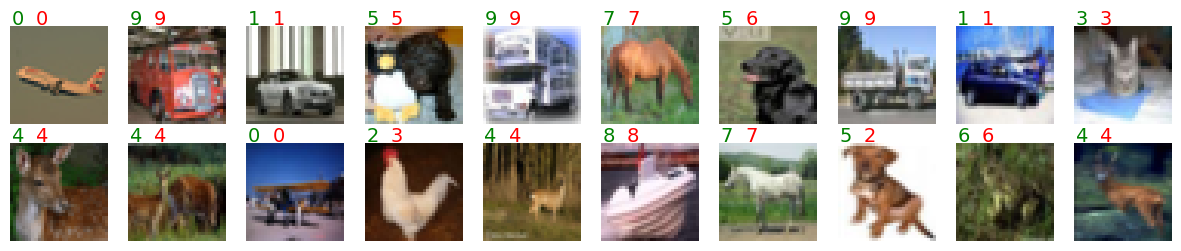

In [16]:
show_errors(combined_model, test_dataloader)